In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\dell\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("ORL Dataset.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

Showing Sample Faces


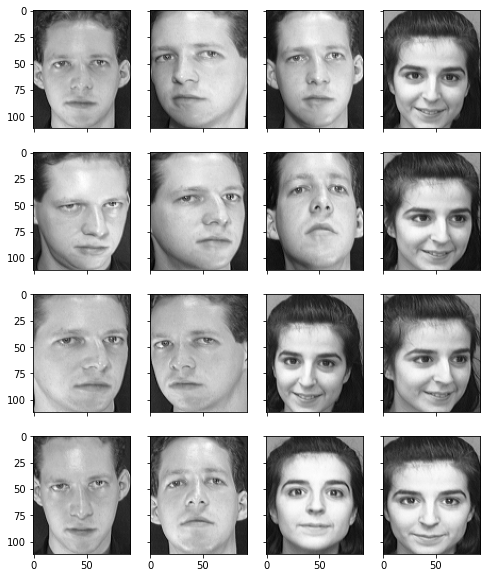

In [3]:
# Show sample faces using matplotlib
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[:16] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing Sample Faces")
plt.show()

In [4]:
# Print some details
faceshape = list(faces.values())[0].shape
print("Face Image Shape:", faceshape)

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of Subjects Detected:", len(classes))
print("Total Number of Images:", len(faces))


Face Image Shape: (112, 92)
Number of Subjects Detected: 40
Total Number of Images: 400


In [5]:
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s88/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

In [6]:
# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)

In [7]:
# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)

In [8]:
n_components = 50
eigenfaces = pca.components_[:n_components]

Showing the Eigenfaces


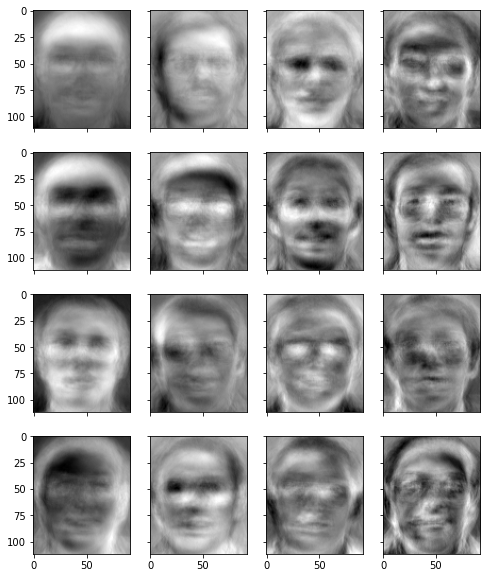

In [9]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the Eigenfaces")
plt.show()

In [10]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the Weight Matrix:", weights.shape)

Shape of the Weight Matrix: (50, 390)


In [11]:
# Test on out-of-sample image of existing class
query = faces["s8/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best Match %s with Euclidean Distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

Best Match s8 with Euclidean Distance 0.000000


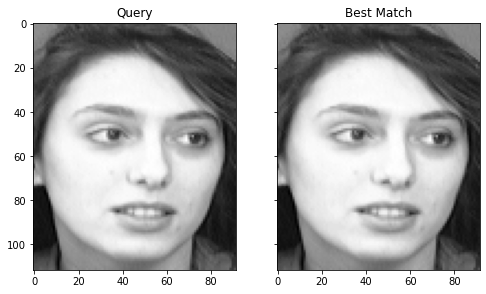

In [12]:
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best Match")
plt.show()

In [13]:
# Test on out-of-sample image of new class
query = faces["s40/6.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best Match %s with Euclidean Distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

Best Match s5 with Euclidean Distance 2185.798811


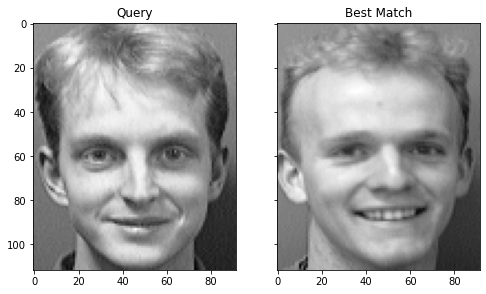

In [14]:
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best Match")
plt.show()